In [2]:
import pandas as pd
import numpy as np

In [3]:
reviews = pd.read_csv("http://data.insideairbnb.com/canada/on/toronto/2024-01-08/data/reviews.csv.gz")

In [4]:
print(reviews.head())

   listing_id         id        date  reviewer_id reviewer_name  \
0        1419   38924112  2015-07-19     11308465       Marcela   
1        1419   44791978  2015-08-29      9580285         Marco   
2        1419   45957133  2015-09-07     38394721        Andrea   
3        1419   67295154  2016-03-28      3515044         Shaun   
4        1419  177702208  2017-08-03     13987100          Kate   

                                            comments  
0  Having the opportunity of arriving to Alexandr...  
1  We have no enough words to describe how beauty...  
2  The listing was exceptional and an even better...  
3  Alexandra's home was amazing and in such a nea...  
4  Beautiful home. Very comfortable and clean. Pe...  


In [5]:
#basic info about the dataset
print(reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511139 entries, 0 to 511138
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     511139 non-null  int64 
 1   id             511139 non-null  int64 
 2   date           511139 non-null  object
 3   reviewer_id    511139 non-null  int64 
 4   reviewer_name  511139 non-null  object
 5   comments       511072 non-null  object
dtypes: int64(3), object(3)
memory usage: 23.4+ MB
None


Since ydata-profiling doesn't seem to work with the entire dataset, lets use a sample

In [ ]:
!pip install ydata-profiling
from ydata_profiling import ProfileReport

sample=reviews.sample(n=50)
profile = ProfileReport(sample, title = "Sample Report")
profile.to_file("sample_report.html")

Now lets check the missing values

In [6]:
#missing values check
missing_values_count = reviews.isna().sum().sort_values(ascending=False)

print("Missing values count in each column (descending order):")
print(missing_values_count)

Missing values count in each column (descending order):
comments         67
listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
dtype: int64


In [7]:
#remove missing values
reviews.dropna(inplace=True)

Let's correct the datatypes

In [8]:
reviews['listing_id'] = reviews['listing_id'].astype('category')
reviews['id'] = reviews['id'].astype('category')
reviews['reviewer_id'] = reviews['reviewer_id'].astype('category')
reviews['date'] = pd.to_datetime(reviews['date'])

Now lets see the summary statistics for the different attributes

In [9]:
from tabulate import tabulate

reviews_summary_statistics=reviews.describe(include='all', datetime_is_numeric=True).T
print(tabulate(reviews_summary_statistics, headers='keys', tablefmt='psql', floatfmt=".2f"))

+---------------+-----------+-----------+-------------+---------+-------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|               |     count |    unique | top         |    freq | mean                          | min                 | 25%                 | 50%                 | 75%                 | max                 |
|---------------+-----------+-----------+-------------+---------+-------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| listing_id    | 511072.00 |  15128.00 | 18154899.0  | 1018.00 | NaT                           | NaT                 | NaT                 | NaT                 | NaT                 | NaT                 |
| id            | 511072.00 | 511072.00 | 7830.0      |    1.00 | NaT                           | NaT                 | NaT                 | NaT                 | NaT 

In [10]:
#calculate length of each review and add it as a new column

reviews['review_length'] = reviews['comments'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

In [11]:
# calculate average word length
average_word_length = reviews['comments'].apply(lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x).split()) > 0 else 0).mean()  # Average word length
print(f"Average Word Length: {average_word_length:.2f}")

Average Word Length: 5.27


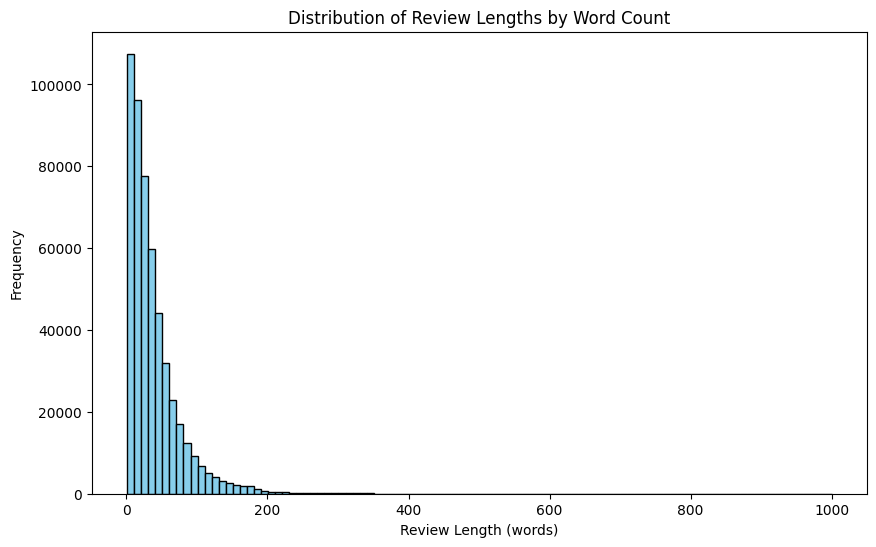

In [12]:
import matplotlib.pyplot as plt

#Histogram of review lengths by word count
plt.figure(figsize=(10, 6))
plt.hist(reviews['review_length'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths by Word Count')
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()

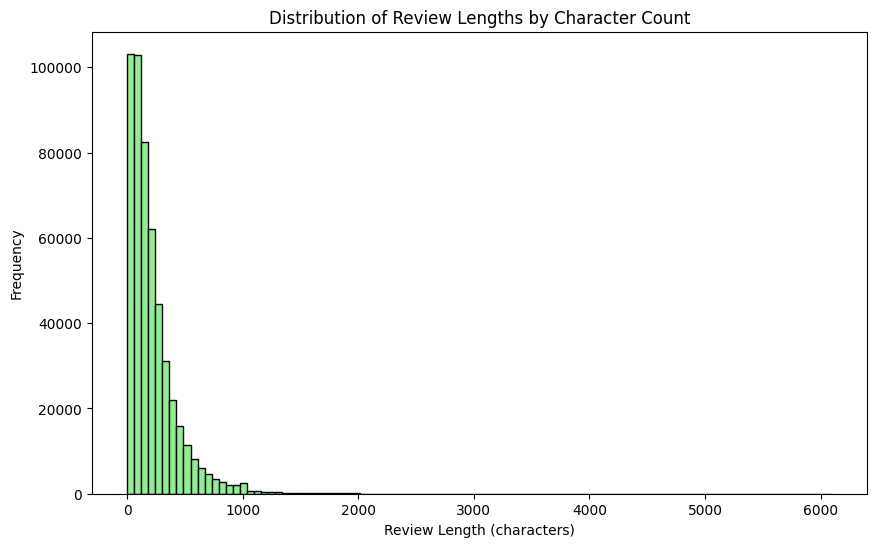

In [13]:
# Histogram of review lengths by character count
plt.figure(figsize=(10, 6))
plt.hist(reviews['comments'].apply(lambda x: len(str(x))), bins=100, color='lightgreen', edgecolor='black')
plt.title('Distribution of Review Lengths by Character Count')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.show()

In [14]:
#unique word analysis

from collections import Counter

all_words = [word for comment in reviews['comments'].dropna() for word in str(comment).lower().split()]
word_counts = Counter(all_words)

print(f"Total unique words: {len(word_counts)}")

Total unique words: 323385


In [19]:
# BIVARIATE ANALYSIS - comment length and date

# Calculate average comment length by year
average_comment_length_by_year = reviews.groupby('year')['review_length'].mean().reset_index()
print(average_comment_length_by_year)

    year  review_length
0   2009      47.285714
1   2010      70.760563
2   2011      66.928270
3   2012      72.012626
4   2013      72.460638
5   2014      70.286909
6   2015      64.124984
7   2016      54.617915
8   2017      42.381619
9   2018      39.377624
10  2019      35.341672
11  2020      32.531220
12  2021      35.091828
13  2022      36.536423
14  2023      36.641238
15  2024      33.827368


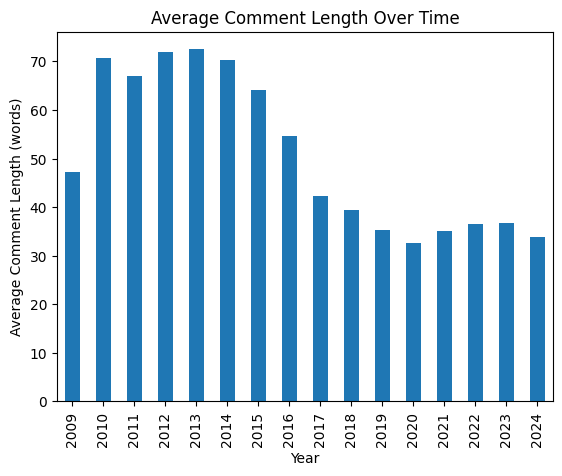

In [18]:
#plot review length over time
reviews['year'] = reviews['date'].dt.year

#plot average comment length by year
reviews.groupby('year')['review_length'].mean().plot(kind='bar', title='Average Comment Length Over Time')
plt.ylabel('Average Comment Length (words)')
plt.xlabel('Year')
plt.show()

In [20]:
#detect languages

!pip install langdetect

from langdetect import detect, LangDetectException

In [21]:
# language detection function

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"  # Return 'unknown' if language detection fails

# Apply the language detection function to each review - add in new language column
reviews['language'] = reviews['comments'].apply(lambda x: detect_language(str(x)))

# Now, let's take a look at the distribution of languages
language_distribution = reviews['language'].value_counts()

print(language_distribution)

en         460085
fr          17525
es           9958
de           3214
pt           2672
zh-cn        2656
ro           2319
ko           1785
unknown      1384
so           1321
it            944
af            931
ca            809
nl            717
ja            523
tl            510
cs            474
pl            384
ru            322
zh-tw         250
sw            224
hr            222
no            222
cy            183
tr            177
id            171
da            165
sv            162
hu            142
vi            107
fi             91
et             80
sl             77
uk             76
he             56
sk             53
ar             15
el             13
lt             13
lv             11
sq              9
bg              7
mk              5
th              4
fa              2
ur              1
gu              1
Name: language, dtype: int64


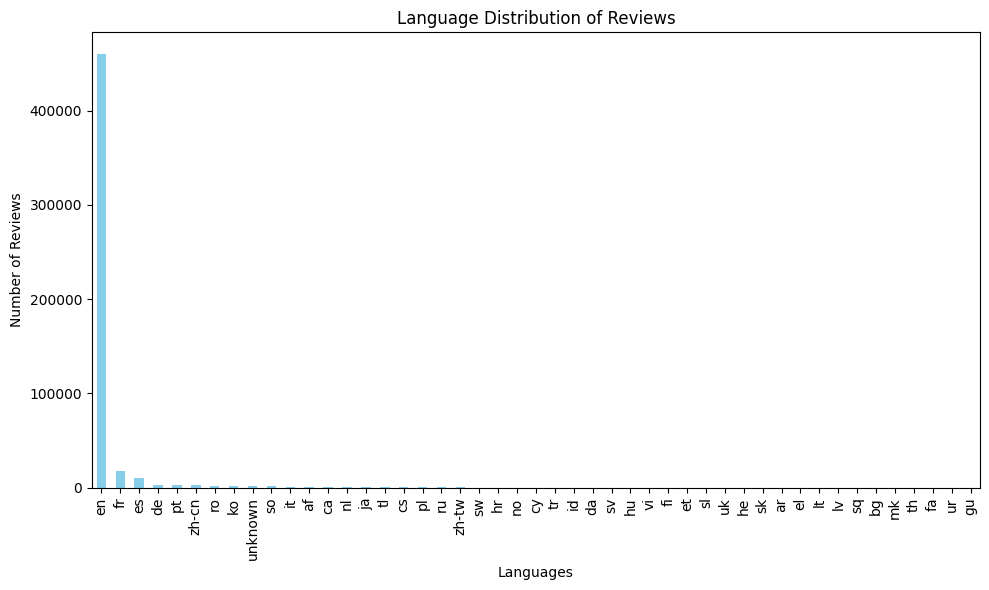

In [22]:
import matplotlib.pyplot as plt

#plot language distributions
language_distribution = reviews['language'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
language_distribution.plot(kind='bar', color='skyblue')
plt.xlabel('Languages')
plt.ylabel('Number of Reviews')
plt.title('Language Distribution of Reviews')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [23]:
# Display samples of 'unknown' language reviews
unknown_reviews = reviews[reviews['language'] == 'unknown']['comments'].sample(n=5)
print("Unknown Language Reviews Sample:")
print(unknown_reviews)

Unknown Language Reviews Sample:
224962    👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌 excel...
472639                                                    -
193879                                                    .
380117                                                    .
286244                                                    .
Name: comments, dtype: object


In [24]:
# delete non engligh - only keep english

reviews = reviews[reviews['language'] == 'en']
reviews.reset_index(drop=True, inplace=True)